# In this notebook, we only focus on cleaning the eviction dataset from:

https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/data_preview

The explainations of the data can be found here: https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/about_data

- The originally downloaded dataset ranges from 2017 - 2025.02.22, but in this notebook, we will ignore the 2025 data, and only focus on 2017 - 2024
- We went from 104,457 records and 20 columns, to 80,477 records 15 columns.
- We treat "court_index_number" as primary keys and dropped records that have the same cour index number but with earlier eviction exected dates. "cour_index_number" is also the primary key on the website.
- We only focus on residential records and drop commercial records (the ratio is roughly 9:1)
- We dropped rows that have NaN in geo data columns

Finally, we saved the cleaned dataset to google drive and will do the visual and data exploration, and eventually test out hypothesis regarding complaints and evictions, clusterings in NYC, and predictions in different notebooks later.

In [244]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import folium
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [245]:
# # load eviction data
# from google.colab import files
# uploaded = files.upload()

# uploaded manually

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/X999/Evictions.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [246]:
# evictions = pd.read_csv(io.BytesIO(uploaded['Evictions_20240918.csv']))
evictions_df_row = pd.read_csv(file_path)

In [247]:
evictions_df = evictions_df_row

In [248]:
evictions_df.head(1)

,Court Index Number,Docket Number,Eviction Address,Eviction Apartment Number,Executed Date,Marshal First Name,Marshal Last Name,Residential/Commercial,BOROUGH,Eviction Postcode,Ejectment,Eviction/Legal Possession,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,22379/19,354582,2915 LA SALLE AVENUE,3R,08/14/2019,Thomas,Bia,Residential,BRONX,10461,Not an Ejectment,Possession,40.839044,-73.830768,10.0,13.0,184.0,2073762.0,2.053580e+09,Schuylerville-Throgs Neck-Edgewater Park


In [249]:
evictions_df.shape

(104457, 20)

In [250]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104457 entries, 0 to 104456
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Court Index Number         104457 non-null  object 
 1   Docket Number              104457 non-null  int64  
 2   Eviction Address           104457 non-null  object 
 3   Eviction Apartment Number  88714 non-null   object 
 4   Executed Date              104457 non-null  object 
 5   Marshal First Name         104457 non-null  object 
 6   Marshal Last Name          104457 non-null  object 
 7   Residential/Commercial     104457 non-null  object 
 8   BOROUGH                    104457 non-null  object 
 9   Eviction Postcode          104457 non-null  int64  
 10  Ejectment                  104457 non-null  object 
 11  Eviction/Legal Possession  104457 non-null  object 
 12  Latitude                   95049 non-null   float64
 13  Longitude                  95

In [251]:
evictions_df.columns

Index(['Court Index Number', 'Docket Number ', 'Eviction Address',
       'Eviction Apartment Number', 'Executed Date', 'Marshal First Name',
       'Marshal Last Name', 'Residential/Commercial', 'BOROUGH',
       'Eviction Postcode', 'Ejectment', 'Eviction/Legal Possession',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [252]:
evictions_df['Residential/Commercial'].value_counts()

,count
Residential/Commercial,
Residential,94907
Commercial,9550


In [253]:
# percentage
evictions_df['Residential/Commercial'].value_counts(normalize=True) * 100

,proportion
Residential/Commercial,
Residential,90.857482
Commercial,9.142518


In [254]:
len(evictions_df)

104457

In [255]:
evictions_df["Marshal Last Name"].head()

,Marshal Last Name
0,Bia
1,Rose
2,Bia
3,Guida
4,Grossman


In [256]:
evictions_df["Residential/Commercial"].unique()

array(['Residential', 'Commercial'], dtype=object)

In [257]:
# cleaning functions (later to drop commercials)
def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)

# convert all the column names into lower case, strip the final space, and change the spaces betwen words to "_"
def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    return df

In [258]:
evictions_df.shape

(104457, 20)

In [259]:
evictions_df.columns

Index(['Court Index Number', 'Docket Number ', 'Eviction Address',
       'Eviction Apartment Number', 'Executed Date', 'Marshal First Name',
       'Marshal Last Name', 'Residential/Commercial', 'BOROUGH',
       'Eviction Postcode', 'Ejectment', 'Eviction/Legal Possession',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [260]:
# drop rows that represent commercial units, instead of residentail units
# drop columns that are irrelevant, such as "Marshal Last Name", and "Marshal first Name"

# drop_rows_by_value(evictions_df, "Residential/Commercial", 'Commercial')
drop_columns(evictions_df, ["Marshal Last Name", "Marshal First Name", 'Community Board', 'Council District'])
evictions_df = evictions_df[evictions_df['Residential/Commercial'] != 'Commercial']

In [261]:
evictions_df["Residential/Commercial"].unique()
evictions_df.shape

(94907, 16)

In [262]:
print(evictions_df.isnull().sum())

Court Index Number               0
Docket Number                    0
Eviction Address                 0
Eviction Apartment Number    10896
Executed Date                    0
Residential/Commercial           0
BOROUGH                          0
Eviction Postcode                0
Ejectment                        0
Eviction/Legal Possession        0
Latitude                      6257
Longitude                     6257
Census Tract                  6257
BIN                           6436
BBL                           6436
NTA                           6257
dtype: int64


In [263]:
type(evictions_df["Eviction Apartment Number"][0])

str

In [264]:
# though "eviction apartment number" column has NaN, still keep the strings there, because they might be interesting
# to look at for certain case studies later
evictions_df['Eviction Apartment Number'].fillna("unknown", inplace=True)

In [265]:
print(evictions_df.isnull().sum())

Court Index Number              0
Docket Number                   0
Eviction Address                0
Eviction Apartment Number       0
Executed Date                   0
Residential/Commercial          0
BOROUGH                         0
Eviction Postcode               0
Ejectment                       0
Eviction/Legal Possession       0
Latitude                     6257
Longitude                    6257
Census Tract                 6257
BIN                          6436
BBL                          6436
NTA                          6257
dtype: int64


In [266]:
evictions_df.dropna(inplace=True)

In [267]:
# sanity check
evictions_df.shape, \
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88471 entries, 0 to 104456
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Court Index Number         88471 non-null  object 
 1   Docket Number              88471 non-null  int64  
 2   Eviction Address           88471 non-null  object 
 3   Eviction Apartment Number  88471 non-null  object 
 4   Executed Date              88471 non-null  object 
 5   Residential/Commercial     88471 non-null  object 
 6   BOROUGH                    88471 non-null  object 
 7   Eviction Postcode          88471 non-null  int64  
 8   Ejectment                  88471 non-null  object 
 9   Eviction/Legal Possession  88471 non-null  object 
 10  Latitude                   88471 non-null  float64
 11  Longitude                  88471 non-null  float64
 12  Census Tract               88471 non-null  float64
 13  BIN                        88471 non-null  float64

((88471, 16), None)

In [268]:
evictions_df = clean_column_names(evictions_df)

In [269]:
evictions_df.shape, \
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88471 entries, 0 to 104456
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   court_index_number         88471 non-null  object 
 1   docket_number              88471 non-null  int64  
 2   eviction_address           88471 non-null  object 
 3   eviction_apartment_number  88471 non-null  object 
 4   executed_date              88471 non-null  object 
 5   residential/commercial     88471 non-null  object 
 6   borough                    88471 non-null  object 
 7   eviction_postcode          88471 non-null  int64  
 8   ejectment                  88471 non-null  object 
 9   eviction/legal_possession  88471 non-null  object 
 10  latitude                   88471 non-null  float64
 11  longitude                  88471 non-null  float64
 12  census_tract               88471 non-null  float64
 13  bin                        88471 non-null  float64

((88471, 16), None)

In [270]:
len(evictions_df.court_index_number.unique()), \
len(evictions_df.docket_number.unique())

(82473, 75088)

In [271]:
# 81888 - 76484

In [272]:
evictions_df.drop_duplicates(inplace=True)

In [273]:
len(evictions_df.court_index_number.unique()), \
len(evictions_df.docket_number.unique())

(82473, 75088)

In [274]:
# since all rows are residential now, drop the column that indicates if it is residential or commercial
evictions_df.drop(columns=['residential/commercial'], inplace=True)

In [286]:
# drop duplicates based on court_index_number
# evictions_df = evictions_df.drop_duplicates(subset=['court_index_number'])

In [276]:
evictions_df.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

In [277]:
evictions_df.shape, \
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82473 entries, 0 to 104456
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   court_index_number         82473 non-null  object 
 1   docket_number              82473 non-null  int64  
 2   eviction_address           82473 non-null  object 
 3   eviction_apartment_number  82473 non-null  object 
 4   executed_date              82473 non-null  object 
 5   borough                    82473 non-null  object 
 6   eviction_postcode          82473 non-null  int64  
 7   ejectment                  82473 non-null  object 
 8   eviction/legal_possession  82473 non-null  object 
 9   latitude                   82473 non-null  float64
 10  longitude                  82473 non-null  float64
 11  census_tract               82473 non-null  float64
 12  bin                        82473 non-null  float64
 13  bbl                        82473 non-null  float64

((82473, 15), None)

In [278]:
# find some rows that have the same court index number
duplicate_groups = evictions_df.groupby('court_index_number').filter(lambda x: len(x) > 1)
duplicate_groups.head(2)

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,census_tract,bin,bbl,nta


In [279]:
check = evictions_df[evictions_df["court_index_number"] == '307019/20']

# display the filtered rows
check

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,census_tract,bin,bbl,nta
63441,307019/20,108457,505 WEST 54TH STREET,1111,08/16/2022,MANHATTAN,10019,Not an Ejectment,Possession,40.767339,-73.9903,135.0,1087122.0,1.010830e+09,Clinton


In [280]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82473 entries, 0 to 104456
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   court_index_number         82473 non-null  object 
 1   docket_number              82473 non-null  int64  
 2   eviction_address           82473 non-null  object 
 3   eviction_apartment_number  82473 non-null  object 
 4   executed_date              82473 non-null  object 
 5   borough                    82473 non-null  object 
 6   eviction_postcode          82473 non-null  int64  
 7   ejectment                  82473 non-null  object 
 8   eviction/legal_possession  82473 non-null  object 
 9   latitude                   82473 non-null  float64
 10  longitude                  82473 non-null  float64
 11  census_tract               82473 non-null  float64
 12  bin                        82473 non-null  float64
 13  bbl                        82473 non-null  float64

In [281]:
# drop duplicates based on Court Index Number
# cleaned_df = evictions_df.drop_duplicates(subset=['court_index_number'])

In [282]:
evictions_df['executed_date'] = pd.to_datetime(evictions_df['executed_date'])

In [287]:
evictions_df.sort_values(by=['court_index_number', 'executed_date'], inplace=True)

In [288]:
evictions_df = evictions_df.drop_duplicates(subset=['court_index_number'], keep='last')

In [291]:
# only keep the relevant ones
start_date = '2017-01-01'
end_date = '2024-12-31'
date_mask = (evictions_df['executed_date'] >= start_date) & (evictions_df['executed_date'] <= end_date)

In [295]:
evictions_df = evictions_df[date_mask]
sorted_df = evictions_df.sort_values('executed_date')

In [297]:
evictions_df.info(), \
len(evictions_df)

<class 'pandas.core.frame.DataFrame'>
Index: 80477 entries, 7797 to 21704
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   court_index_number         80477 non-null  object        
 1   docket_number              80477 non-null  int64         
 2   eviction_address           80477 non-null  object        
 3   eviction_apartment_number  80477 non-null  object        
 4   executed_date              80477 non-null  datetime64[ns]
 5   borough                    80477 non-null  object        
 6   eviction_postcode          80477 non-null  int64         
 7   ejectment                  80477 non-null  object        
 8   eviction/legal_possession  80477 non-null  object        
 9   latitude                   80477 non-null  float64       
 10  longitude                  80477 non-null  float64       
 11  census_tract               80477 non-null  float64       
 12  bin   

(None, 80477)

In [299]:
sorted_df

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,census_tract,bin,bbl,nta
46638,4150/15EJ,454323,3278 KINGSLAND AVENU E,*,2017-01-03,BRONX,10469,Ejectment,Possession,40.875117,-73.843328,358.0,2061514.0,2.047520e+09,Eastchester-Edenwald-Baychester
30294,29475/16,324496,2861 GRACE AVENUE,2,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.869247,-73.834603,46202.0,2114011.0,2.047990e+09,Co-op City
15599,68328/16,459862,747 10TH AVENUE,17D,2017-01-03,MANHATTAN,10019,Not an Ejectment,Possession,40.765094,-73.991502,135.0,1083800.0,1.010799e+09,Clinton
8802,71366/16,7567,70-20 261 STREET,unknown,2017-01-03,QUEENS,11004,Not an Ejectment,Possession,40.753507,-73.718358,155102.0,4459247.0,4.084430e+09,Glen Oaks-Floral Park-New Hyde Park
25901,N061066/09,373033,4-6 WEST 105TH STREET,4A,2017-01-03,MANHATTAN,10025,Not an Ejectment,Possession,40.797472,-73.960791,189.0,1055498.0,1.018400e+09,Upper West Side
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75414,308123/24,23218,45 BRADHURST AVENUE APT 1,1,2024-12-26,MANHATTAN,10030,Not an Ejectment,Possession,40.822848,-73.943318,227.0,1061113.0,1.020510e+09,Hamilton Heights
78140,314456/24,22735,370 WEST 52ND STREET APT 3-B,3-B,2024-12-26,MANHATTAN,10019,Not an Ejectment,Possession,40.764435,-73.987336,133.0,1078889.0,1.010420e+09,Clinton
39261,308611/20,21653,1629 ST JOHNS PLACE APT. 4F,4F,2024-12-27,BROOKLYN,11233,Not an Ejectment,Possession,40.670179,-73.923408,359.0,3036936.0,3.013810e+09,Crown Heights North
71721,306966/24,22953,119 BAXTER STREET APARTMENT 8R,8R,2024-12-27,MANHATTAN,10013,Not an Ejectment,Possession,40.718065,-73.998975,41.0,1079542.0,1.002060e+09,SoHo-TriBeCa-Civic Center-Little Italy


In [315]:
# final eviction df sanity check
evictions_df.shape, \
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80477 entries, 7797 to 21704
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   court_index_number         80477 non-null  object        
 1   docket_number              80477 non-null  int64         
 2   eviction_address           80477 non-null  object        
 3   eviction_apartment_number  80477 non-null  object        
 4   executed_date              80477 non-null  datetime64[ns]
 5   borough                    80477 non-null  object        
 6   eviction_postcode          80477 non-null  int64         
 7   ejectment                  80477 non-null  object        
 8   eviction/legal_possession  80477 non-null  object        
 9   latitude                   80477 non-null  float64       
 10  longitude                  80477 non-null  float64       
 11  census_tract               80477 non-null  float64       
 12  bin   

((80477, 16), None)

In [ ]:
# evictions_df.head()

In [316]:
# save cleaned evictions data to my drive
sorted_df.to_csv('/content/drive/My Drive/X999/evictions_df_cleaned.csv', index=False)

#### For the write-up: do a check on each year's eviction numbers

In [302]:
evictions_df['year'] = evictions_df['executed_date'].dt.year
df_2017 = evictions_df[evictions_df['year'] == 2017]
print("2017", len(df_2017))
df_2018 = evictions_df[evictions_df['year'] == 2018]
print("2018", len(df_2018))
df_2019 = evictions_df[evictions_df['year'] == 2019]
print("2019", len(df_2019))
df_2020 = evictions_df[evictions_df['year'] == 2020]
print("2020", len(df_2020))
df_2021 = evictions_df[evictions_df['year'] == 2021]
print("2021", len(df_2021))
df_2022 = evictions_df[evictions_df['year'] == 2022]
print("2022", len(df_2022))
df_2023 = evictions_df[evictions_df['year'] == 2023]
print("2023", len(df_2023))
df_2024 = evictions_df[evictions_df['year'] == 2024]
print("2024", len(df_2024))

2017 18041
2018 17193
2019 14789
2020 2672
2021 123
2022 3587
2023 10598
2024 13474


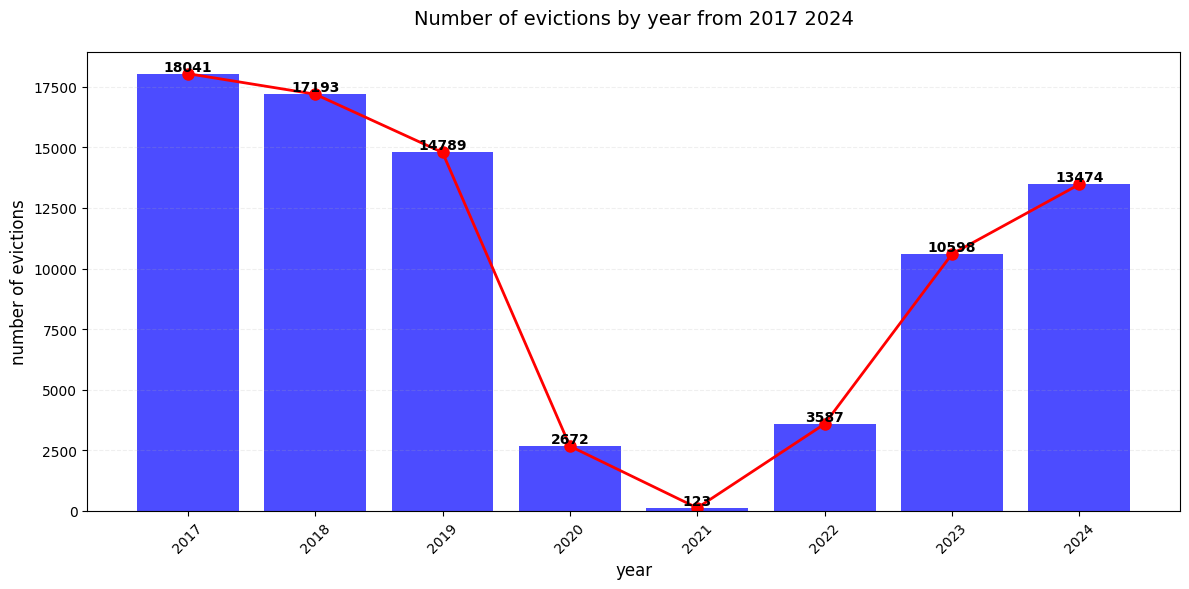

In [314]:
# count evictions by year
yearly_counts = evictions_df.groupby(evictions_df['executed_date'].dt.year).size()
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(yearly_counts.index, yearly_counts.values, color='blue', alpha=0.7)
ax.plot(yearly_counts.index, yearly_counts.values, color='red', marker='o', linewidth=2, markersize=8)

# plot
plt.title('Number of evictions by year from 2017 2024', fontsize=14, pad=20)
plt.xlabel('year', fontsize=12)
plt.ylabel('number of evictions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.xticks(yearly_counts.index, rotation=45)

# value labels
for i, v in enumerate(yearly_counts):
    ax.text(yearly_counts.index[i], v, str(v),
            ha='center', va='bottom',
            fontweight='bold')

plt.tight_layout()
plt.show()

In [313]:
print("Evictions per year:")
print(yearly_counts)

Evictions per year:
executed_date
2017    18041
2018    17193
2019    14789
2020     2672
2021      123
2022     3587
2023    10598
2024    13474
dtype: int64
